# Train XGBoost

In [17]:
import xgboost as xgb
import pandas as pd, numpy as np
import salary
import seaborn as sns
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from skopt import BayesSearchCV
import cloudpickle

In [2]:
sns.set_theme()

In [3]:
(X_train, y_train) = salary.get_train_dataset(include_extracted_salaries=True)

In [4]:
preprocessor = salary.get_preprocessor()
(train_size, num_features) = clone(preprocessor).fit_transform(X_train, y_train).shape
(train_size, num_features)

(32103, 3670)

## Train & Tune Model

In [5]:
model_xgb = make_pipeline(
    clone(preprocessor),
    BayesSearchCV(
        xgb.XGBRegressor(
            random_state=42,
            
            # Uncomment to use GPU
            # device='cuda',
        ),
        # Uncomment to use tuned hyperparameters
        {
            'objective': ['reg:squarederror'],
            'eta': [0.0628],
            'n_estimators': [1000],
            'max_depth': [10],
            'min_child_weight': [100],
            'subsample': [1.0],
            'colsample_bytree': [0.1],
            'gamma': [1]
        },
        # Uncomment to tune hyperparameters
        # {
        #     'objective': ['reg:tweedie', 'reg:squarederror'],
        #     'eta': (0.01, 0.3, 'log-uniform'),  # Learning rate
        #     'n_estimators': (50, 1000),  # Number of trees to build
        #     'max_depth': (3, 10),  # Control model complexity
        #     'min_child_weight': (10, 100),  # Minimum sum of instance weight needed in a child
        #     'subsample': (0.5, 1.0),  # Fraction of samples used for tree building
        #     'colsample_bytree': (0.1, 1.0),  # Fraction of features used for tree building
        #     'gamma': (0, 1),  # Minimum loss reduction for further partition
        # },
        scoring='r2',
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        n_iter=1, 
        # n_iter=50,
        verbose=3,
        random_state=42
    )
).fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END colsample_bytree=0.1, eta=0.0628, gamma=1, max_depth=10, min_child_weight=100, n_estimators=1000, objective=reg:squarederror, subsample=1.0;, score=0.654 total time= 2.2min
[CV 2/5] END colsample_bytree=0.1, eta=0.0628, gamma=1, max_depth=10, min_child_weight=100, n_estimators=1000, objective=reg:squarederror, subsample=1.0;, score=0.629 total time= 2.2min
[CV 3/5] END colsample_bytree=0.1, eta=0.0628, gamma=1, max_depth=10, min_child_weight=100, n_estimators=1000, objective=reg:squarederror, subsample=1.0;, score=0.660 total time= 2.1min
[CV 4/5] END colsample_bytree=0.1, eta=0.0628, gamma=1, max_depth=10, min_child_weight=100, n_estimators=1000, objective=reg:squarederror, subsample=1.0;, score=0.614 total time= 2.2min
[CV 5/5] END colsample_bytree=0.1, eta=0.0628, gamma=1, max_depth=10, min_child_weight=100, n_estimators=1000, objective=reg:squarederror, subsample=1.0;, score=0.674 total time= 2.2min


In [6]:
model_xgb

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('title_sbert_pca_encoder',
                                                                   Pipeline(steps=[('sentencebertencoder',
                                                                                    SentenceBertEncoder())]),
                                                                   ['title']),
                                                                  ('location_sbert_pca_encoder',
                                                                   Pipeline(steps=[('sentencebertencoder',
                                                                                    SentenceBertEncoder())]),
                                                                   ['location']),
                                                                  ('company_industries_sbert_pca_encoder',
                                                                   Pip...
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...),
                               n_iter=1, random_state=42, scoring='r2',
                               search_spaces={'colsample_bytree': [0.1],
                                              'eta': [0.0628], 'gamma': [1],
                                              'max_depth': [10],
                                              'min_child_weight': [100],
                                              'n_estimators': [1000],
                                              'objective': ['reg:squarederror'],
                                              'subsample': [1.0]},
                               verbose=3))])

In [7]:
search = model_xgb[-1]
search.cv_results_

{'mean_fit_time': array([129.67356601]),
 'std_fit_time': array([0.75399986]),
 'mean_score_time': array([0.05950718]),
 'std_score_time': array([0.00375547]),
 'param_colsample_bytree': masked_array(data=[0.1],
              mask=[False],
        fill_value=1e+20),
 'param_eta': masked_array(data=[0.0628],
              mask=[False],
        fill_value=1e+20),
 'param_gamma': masked_array(data=[1],
              mask=[False],
        fill_value=999999),
 'param_max_depth': masked_array(data=[10],
              mask=[False],
        fill_value=999999),
 'param_min_child_weight': masked_array(data=[100],
              mask=[False],
        fill_value=999999),
 'param_n_estimators': masked_array(data=[1000],
              mask=[False],
        fill_value=999999),
 'param_objective': masked_array(data=['reg:squarederror'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_subsample': masked_array(data=[1.0],
              mask=[False],
        fill_va

In [8]:
search.best_params_

OrderedDict([('colsample_bytree', 0.1),
             ('eta', 0.0628),
             ('gamma', 1),
             ('max_depth', 10),
             ('min_child_weight', 100),
             ('n_estimators', 1000),
             ('objective', 'reg:squarederror'),
             ('subsample', 1.0)])

In [9]:
result_train = salary.evaluate_train_predictions(model_xgb.predict(X_train), y_train)

Train size: 32103
Train R2: 0.9773
Train RMSE: 9087.5974
Train MAE: 5097.4432


## Evaluate on Test Set

In [10]:
(X_test, y_test) = salary.get_test_dataset()

In [11]:
result_test = salary.evaluate_test_predictions(model_xgb.predict(X_test))

Test size: 10000
Test R2: 0.6430
Test RMSE: 35808.1369
Test MAE: 21779.1809


## Check Feature Importance

,Feature,Importance
0,company_industries_sbert_pca_encoder__company_...,0.018474
1,enum_one_hot_encoder__formatted_experience_lev...,0.014983
2,company_industries_sbert_pca_encoder__company_...,0.013555
3,enum_one_hot_encoder__formatted_experience_lev...,0.0119
4,company_industries_sbert_pca_encoder__company_...,0.011879
5,education_sbert_pca_encoder__extracted_educati...,0.01082
6,enum_one_hot_encoder__formatted_experience_lev...,0.010484
7,education_sbert_pca_encoder__extracted_educati...,0.009525
8,company_industries_sbert_pca_encoder__company_...,0.009331
9,experience_level__formatted_experience_level,0.008858


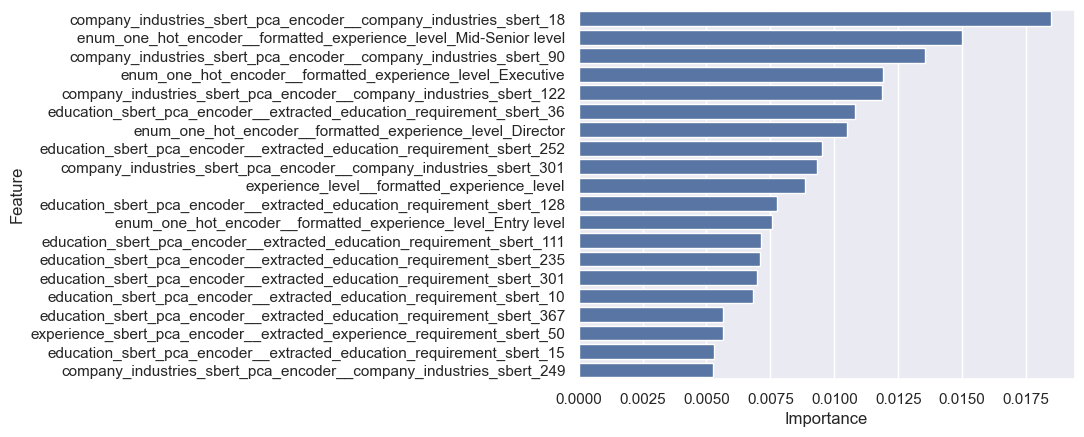

In [12]:
'''
Show top 20 important features
'''
def get_important_features(preocessor, model, n=20):
    feature_names = preocessor.get_feature_names_out(X_train.columns)
    importances = model.feature_importances_
    idxs = np.flip(np.argsort(np.abs(importances)))
    importance_df = pd.DataFrame([feature_names[idxs], importances[idxs]], index=["Feature", "Importance"]).transpose()
    sns.barplot(x="Importance", y="Feature", data=importance_df.head(n))
    return importance_df[:n]


get_important_features(model_xgb[0], model_xgb[-1].best_estimator_)

## Export Model

In [ ]:
with open('models/model_xgb.cloudpickle', 'wb') as f:
    cloudpickle.dump(model_xgb, f)